# Fantasy Football Roster Predictions

## Problem
Use the data provided from past NFL seasons to determine if a machine learning model can help predict and create a winning fantasy football team. Can a model predict a fantasy football roster that can win a fantasy football league?  Every year thousands of fans come together to create their "Dream Team" for a chance to win a cash prize. 

## Data
The data has 8 seperate dataset, consisting of player metrics from the year 2012-2024 for both offense and defense. It ranges from 1600 - 4500+ columns of data, depending on the data used.  We will only be using metrics from the last few years to determine the best players to draft for you fantasy team.

For this project we will only use data provided from yearly player performance and weekly player performance

The data consists of the following:

* Player ID
* Player Name
* Rushing yards
* Passiing yards
* Rushing touchdowns
* Passing touchdowns
* Receiving yards
* Receptions

We will also focus on players that have played 1 or more games throughout the last few years.


### Strategy 
1. Imports & basic configuration
2. Load Data & basic cleaning
3. Feature Engineering
4. Exploratory Visualizations
5. Baseline Regression Model
6. Advanced Models (Random Forest & XG Boost)
7. Time-Series Forecasting (ARIMA)
8. Hybrid Recommendation System (Synthetic ratings, SVD, Hybrid score)
9. Build a draft and Simulate a 2025 Roster

This type of analysis requires metrics from a regression model. In order to determine the best choices for your fatansy draft based on player metrics (Passing touchdowns, passing yards, rushing touchdowns, rush yards, receptions etc...)

# 1) Basic configuration

we will import the information from kaggle [NFL Stats](https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022). This will require importing thr kaggle API from the kaggle library.

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\omend\.kaggle'

api = KaggleApi()
api.authenticate()

api.dataset_download_files("philiphyde1/nfl-stats-1999-2022", path=r"./data", unzip=True)
print("Download Complete!")

Dataset URL: https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022
Download Complete!


##### Importing libraries

We will import the neccesary libraries to build the regression for this project. Starting with a linear Regression model as the baseline.

In [2]:
#Data load and ETL
import pandas as pd
import numpy as np

# Feature engineering and preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#4 REgression & Machine learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,recall_score, precision_score, f1_score
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import spearmanr

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#simple Collaborative FIltering with surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as suprise_split, cross_validate
from surprise import accuracy

#Time series Forecasting
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


# Recommendation & Optimization
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linprog
import pulp

# 2) Load and Cleaning Data

In [3]:
yearly_data_off = pd.read_csv('./data/yearly_player_stats_offense.csv', encoding='utf-8')
yearly_data_def = pd.read_csv('./data/yearly_player_stats_defense.csv', encoding='utf-8')

weekly_data_off = pd.read_csv('./data/weekly_player_stats_offense.csv')
print(yearly_data_off.head(10))
print(weekly_data_off.head(5))

    player_id      player_name position  birth_year  draft_year  draft_round  \
0  00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
1  00-0004541    Donald Driver       WR        1975      1999.0          7.0   
2  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
3  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
4  00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   
5  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
6  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
7  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
8  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
9  00-0015754  Brandon Stokley       WR        1976      1999.0          4.0   

   draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0        30.0       60.0    74.0   216.0

In [4]:
print(yearly_data_off.info())
yearly_data_off.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Columns: 660 entries, player_id to delta_yptouch
dtypes: float64(647), int64(5), object(8)
memory usage: 35.9+ MB
None


,birth_year,draft_year,draft_round,draft_pick,draft_ovr,height,weight,season,shotgun,no_huddle,...,delta_comp_pct,delta_int_pct,delta_pass_td_pct,delta_ypa,delta_yptarget,delta_ypr,delta_rush_td_pct,delta_ypc,delta_td_pct,delta_yptouch
count,7133.000000,7133.000000,6043.000000,6043.000000,6043.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,...,6423.000000,2764.000000,2534.000000,6420.00000,7085.000000,7128.000000,3878.000000,7041.000000,6272.000000,7131.000000
mean,1992.202159,2014.765456,3.318385,17.839980,96.375972,73.300014,219.109211,2018.474835,59.769101,9.374317,...,-0.007925,1.184853,1.022384,0.04747,0.145072,0.142632,0.001036,-0.031899,0.509676,0.274108
std,4.982449,4.905538,1.881082,10.855329,69.298843,2.894479,23.857682,3.609918,103.141334,23.223000,...,0.180886,19.983789,13.974659,0.93722,1.675854,1.624686,2.999953,2.723183,4.915531,2.704527
min,1974.000000,1997.000000,1.000000,1.000000,1.000000,66.000000,155.000000,2012.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-7.52000,-35.320000,-46.760000,-1.000000,-134.333333,-1.000000,-53.500000
25%,1989.000000,2012.000000,2.000000,8.000000,36.000000,71.000000,203.000000,2016.000000,6.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.00000,-0.288762,-0.250357,-0.973500,-0.212714,-0.995000,-0.370634
50%,1993.000000,2015.000000,3.000000,18.000000,85.000000,73.000000,216.000000,2019.000000,24.000000,3.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1996.000000,2018.000000,5.000000,27.000000,149.000000,76.000000,235.000000,2022.000000,67.000000,8.000000,...,0.000000,0.000000,0.000000,0.00000,0.266200,0.273275,0.000000,0.000000,0.000000,0.516560
max,2004.000000,2024.000000,7.000000,47.000000,262.000000,81.000000,347.000000,2024.000000,691.000000,430.000000,...,2.003003,832.333333,284.714286,46.50000,46.200000,34.757576,124.000000,39.000000,199.000000,113.545455


In [5]:
print(weekly_data_off.info())
weekly_data_off.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58629 entries, 0 to 58628
Columns: 393 entries, season to career_average_standard_ppg
dtypes: float64(379), int64(6), object(8)
memory usage: 175.8+ MB
None


,season,week,offense_snaps,offense_pct,team_offense_snaps,birth_year,draft_year,draft_round,draft_pick,draft_ovr,...,career_rush_td_pct,career_ypc,career_td_pct,career_yptouch,career_pass_ypg,career_rec_ypg,career_rush_ypg,career_ypg,career_average_ppr_ppg,career_average_standard_ppg
count,58629.000000,58629.000000,58629.000000,58629.000000,58405.000000,58629.000000,58629.000000,51339.000000,51339.000000,51339.000000,...,41995.000000,41995.000000,58297.000000,58297.000000,58629.000000,58629.000000,58629.000000,58629.000000,58629.000000,58629.000000
mean,2018.390694,9.427655,39.534787,0.592403,66.888263,1992.137406,2014.626021,3.062467,17.273243,86.703695,...,0.036363,4.588108,0.113326,9.565460,27.900316,26.385058,12.514595,5.516799,9.354993,7.073413
std,3.695677,5.326161,20.824732,0.299456,9.256529,5.101613,5.000942,1.803155,10.907683,66.301576,...,0.095732,3.448942,0.132585,4.224161,76.201543,22.596668,21.174594,16.741135,5.677821,5.495966
min,2012.000000,1.000000,0.000000,0.000000,33.000000,1974.000000,1997.000000,1.000000,1.000000,1.000000,...,0.000000,-14.000000,0.000000,-12.000000,-1.000000,-8.000000,-12.000000,-12.000000,-3.100000,-3.100000
25%,2015.000000,5.000000,22.000000,0.340000,60.000000,1989.000000,2011.000000,1.000000,7.000000,32.000000,...,0.000000,3.230000,0.030000,5.900000,0.000000,8.920000,0.000000,0.810000,4.930000,3.180000
50%,2019.000000,9.000000,40.000000,0.620000,67.000000,1993.000000,2015.000000,3.000000,18.000000,73.000000,...,0.016000,4.320000,0.080000,9.680000,0.000000,21.280000,1.220000,1.630000,8.360000,5.580000
75%,2022.000000,14.000000,56.000000,0.860000,73.000000,1996.000000,2018.000000,4.000000,26.000000,133.000000,...,0.039000,5.550000,0.170000,12.560000,0.000000,39.260000,16.710000,4.000000,12.990000,9.270000
max,2024.000000,22.000000,100.000000,1.000000,100.000000,2004.000000,2024.000000,7.000000,47.000000,262.000000,...,1.000000,51.500000,2.030000,93.000000,388.000000,147.000000,181.000000,445.000000,50.620000,50.620000


In [6]:
print(yearly_data_off.isnull().sum()[yearly_data_off.isnull().sum() > 0].to_string())


draft_round                                         1090
draft_pick                                          1090
draft_ovr                                           1090
offense_pct                                          179
years_exp                                             18
season_team_offense_snaps                            179
career_team_offense_snaps                            174
career_average_shotgun                              1134
career_average_no_huddle                            1134
career_average_qb_dropback                          1134
career_average_qb_scramble                          1134
career_average_pass_attempts                        1134
career_average_complete_pass                        1134
career_average_incomplete_pass                      1134
career_average_passing_yards                        1134
career_average_receiving_yards                      1134
career_average_yards_after_catch                    1134
career_average_rush_attempts   

we print out the information for both yearly and weekly stats to see how much data we're working with. We will also check if any of the data we will be using is missing any data. We can see that none of our data is missing the neccessary information needed.


As mentioned earlier we will only use stats from the last few seasons. I'll use the last three years. One, on average it takes a player roughly 2-3 seasons to find their footing within the NFL. Two, Using data from the last three years allows the ability to locate players stats and progression between teams, meaning if the player was traded or released and then picked up by another team

In [7]:
#Filter only 2021-2024 seasons
yearly_data_off = yearly_data_off[yearly_data_off['season'].isin([2021,2022,2023, 2024])]
weekly_data_off = weekly_data_off[weekly_data_off['season'].isin([2021, 2022, 2023, 2024])]

In [8]:
#drop players with no games played

yearly_data_off = yearly_data_off[yearly_data_off['games_played_season'] > 0]
weekly_data_off = weekly_data_off[weekly_data_off['games_played_season'] > 0]

# 3) Feature engineering: rolling weekly features & merge yearly features

We further filtered any player that has no played any games within theses seasons. Removing them from contension

In [9]:
#Keep some aggregate features
yearly_features = yearly_data_off[['player_id', 'player_name','season', 'passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr']]

Let's narrow down the features we want to use for this analysis and save it. These determine a players value in fantasy and shows if the player will be a good pick for a fantasy football roster. Since we're focused solely on fantasy points we will keep this feature along with all of the aforementioned features.

In [10]:
# rolling averages: last 3 weeks players
weekly_data_off = weekly_data_off.sort_values(['player_id','season','week'])

weekly_data_off['fp_last3'] = (
    weekly_data_off.groupby('player_id')['fantasy_points_ppr'].transform(lambda x: x.rolling(3, min_periods=1).mean())
)

weekly_features = weekly_data_off[['player_id','player_name','season','week','passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr','fp_last3']]

In [11]:
#Merge yearly summary into weekly data
data_merged = weekly_features.merge(yearly_features, on=['player_id','season'],
                                    suffixes=('_weekly','_yearly'))

print(data_merged.dtypes)

player_id                      object
player_name_weekly             object
season                          int64
week                            int64
passing_yards_weekly          float64
pass_touchdown_weekly         float64
rushing_yards_weekly          float64
rush_touchdown_weekly         float64
receptions_weekly             float64
receiving_yards_weekly        float64
receiving_touchdown_weekly    float64
fantasy_points_ppr_weekly     float64
fp_last3                      float64
player_name_yearly             object
passing_yards_yearly          float64
pass_touchdown_yearly         float64
rushing_yards_yearly          float64
rush_touchdown_yearly         float64
receptions_yearly             float64
receiving_yards_yearly        float64
receiving_touchdown_yearly    float64
fantasy_points_ppr_yearly     float64
dtype: object


We sorted the weekly data to place in the corret order since theres more input of data throughout the seasons. Then we find the rolling average of players for the final 3 weeks.

Afterwards, we keep the features that we want to use for our regression model, just like the yearly data we are focused on fantasy points so we will keep this as well, creating a new columns called "fp_last3" within the weekly data offense dataset.

Let's look at some exploratory visualizations

# 4) Exploratory Visualizations

4a) Distribution of weekly fantasy points

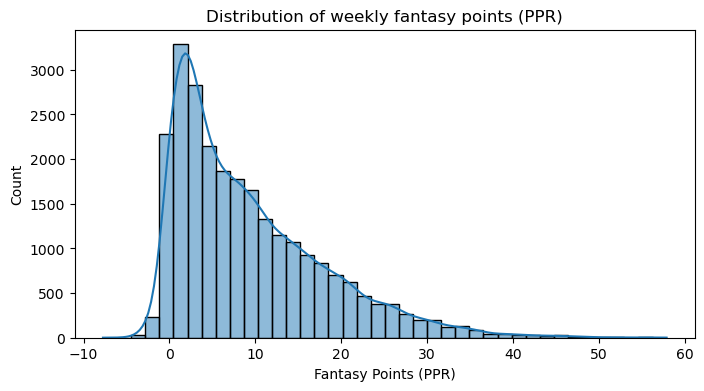

In [12]:
# Distribution  of weekly fantasy points

plt.figure(figsize=(8,4))
sns.histplot(data_merged['fantasy_points_ppr_weekly'].dropna(), bins=40, kde=True)
plt.title("Distribution of weekly fantasy points (PPR)")
plt.xlabel("Fantasy Points (PPR)")
plt.show()

This visualization shows the distribution of weekly fantasy point(PPR) for players.

The distribution is right skewed(positively skewed)

* Most players score very score fantasy points in a given week(clustered around 0-10 points)
* The peak appears around 3-5 points, most players fall into this range.
* Fewer players schieve very high points totals(the long tail extending to the right toward 50+ points).
* In football, it's a rarity to obtain anything over 25 points. Any player with 30 points or more (Outliers), showing a few exceptional performances.
* We will focus weekly performances from 10-20points. This helps determine if a player is consistent weekly and able to generate points for yout team.


Since the distribution is skewed, using the median may be better measure of "Typical" performance than the mean.

4b) Correlation heatmap for numric features

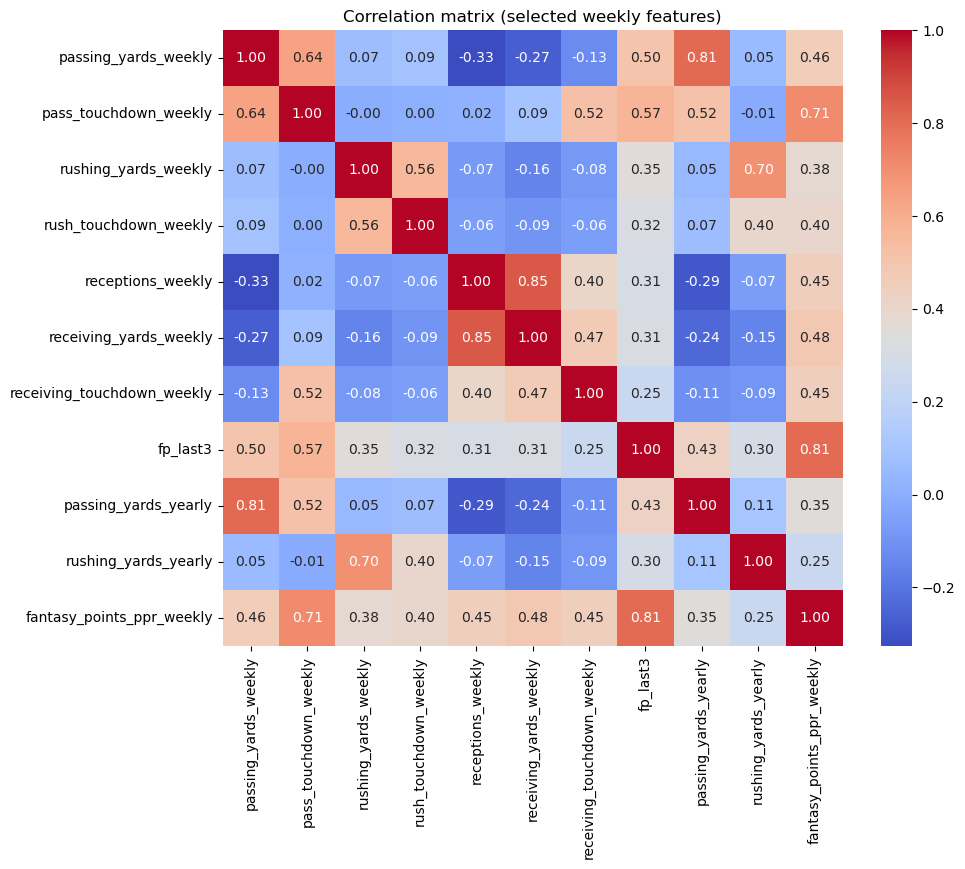

In [13]:
#player Weekly Trends

numcols = [
 'passing_yards_weekly','pass_touchdown_weekly','rushing_yards_weekly','rush_touchdown_weekly',
 'receptions_weekly','receiving_yards_weekly','receiving_touchdown_weekly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly', 'fantasy_points_ppr_weekly'
]
subset = data_merged[[c for c in numcols if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected weekly features)")
plt.show()

This heatmap shows the correlation of selected weekly fantasy football features.

Receiving stats are highly correlated
* reception_weekly and receiving_yards_weekly (0.85). Players who catch more passes also gain more receiving yards.

Passing stats are correlated
* paassing_yards_weekly and passing_touchdown_weekly also tend to throw more touchdowns

Fanstasy points correlate most with touchdowns
* fantasy_points_ppr_weekly has a strong and moderate correlation with pass_touchdown_weekly (0.71) and moderate correlation with receiving and rushing stats (0.38-0.48)

This supports our original strategy that touchdowns are a major driver of weekly fantasy points.

4c) Player weekly trend

We will a player to demonstrate the weekly trends based on performance, we'll use Patrick Mahomes. During the 2021 NFL season, alone with a 3-week rolling average that smooths out week-to-week fluctuations.


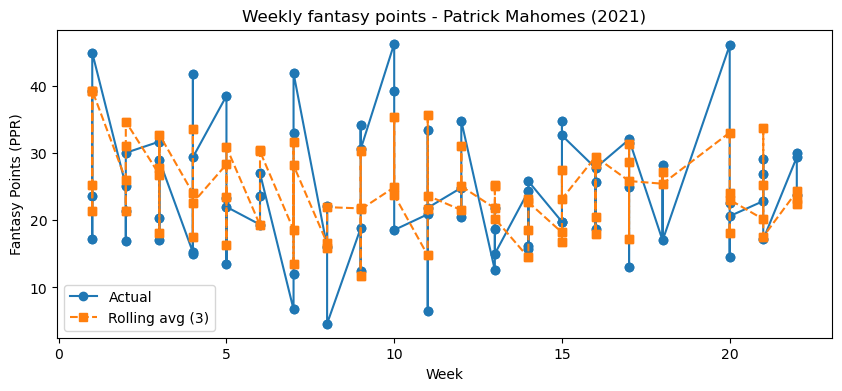

In [14]:
player_name = "Patrick Mahomes"  # change to a name in your data
df_p = data_merged[data_merged['player_name_weekly']==player_name].sort_values('week')
if df_p.empty:
    print("Player not found. Try a different name. Example player_name values:", data_merged['player_name_weekly'].unique()[:10])
else:
    plt.figure(figsize=(10,4))
    plt.plot(df_p['week'], df_p['fantasy_points_ppr_weekly'], marker='o', label='Actual')
    if 'fp_last3' in df_p.columns:
        plt.plot(df_p['week'], df_p['fp_last3'], marker='s', linestyle='--', label='Rolling avg (3)')
    plt.title(f"Weekly fantasy points - {player_name} ({df_p['season'].iloc[0]})")
    plt.xlabel("Week")
    plt.ylabel("Fantasy Points (PPR)")
    plt.legend()
    plt.show()


In this example, we can see a high variability in weekly performance.

* Mahomes' weekly fantasy points fluctuate significantly, ranging from below 10 points in some weeks to over 40 points in others.
* This indicates that while he is a top-performing quarterback, his fantasy production can be inconsistent week to week.
* The orange dashed line (3-week rolling average) smooths the ups and downs, making overall trends clearer.
* The rolling average shows Mahomes' short-term form, useful for identifying hot streaks or slumps.

This chart shows that Patrick Mahomes’ fantasy performance in 2021 was highly variable from week to week, with several explosive games balanced by a few low-scoring weeks. The 3-week rolling average reveals short-term trends, showing periods of strong consistency and midseason dips in production.

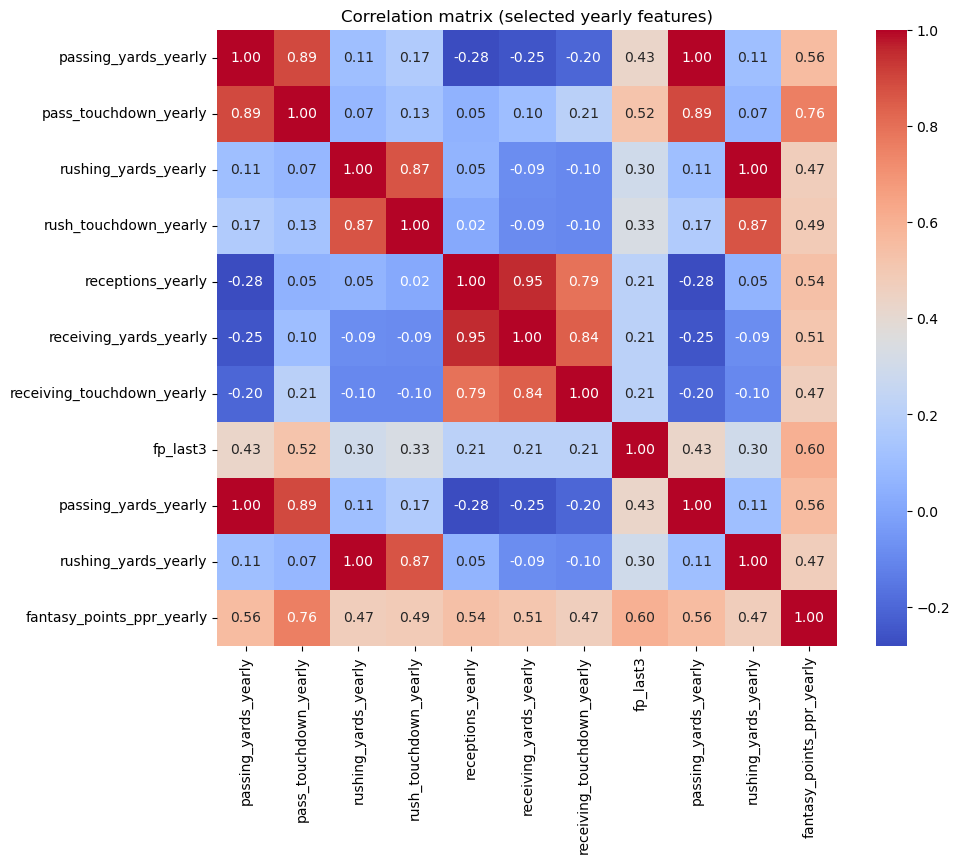

In [15]:
numcols_yr = [
 'passing_yards_yearly','pass_touchdown_yearly','rushing_yards_yearly','rush_touchdown_yearly',
 'receptions_yearly','receiving_yards_yearly','receiving_touchdown_yearly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly', 'fantasy_points_ppr_yearly'
]
subset = data_merged[[c for c in numcols_yr if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected yearly features)")
plt.show()

This heatmap displays correlation for attributes of fantasy on a yearly basis.

High Correlation with Rushing stats
* rushing_yards_yearly and rushing_yards_touchdown_yearly have a high correlation of 0.81. 
* Moderate correlation to Fantasy_points_ppr_yearly at 0.49, falling shy of 50% of points that generate fantasy points each year.

Passing stats have high correlation
* pass_touchdown_yearly, passing_yards_yearly have a correlation of 0.89. Reception_yearly and receiving_yards_yearly have a correlation of 0.95, reception_yearly and receiving_touchdown_yearly have a correlation of 0.79
* A moderate correlation to fantasy_points_pr_yearly of 0.51 making it the preferred method of obtaining fantasy points each year.

We can focus on the poisition and players that provide the best stats for these points(WR, RB, QB) 



In [27]:
# -----------------------------
# 1. Define features and target
# -----------------------------
features = [
    'passing_yards_weekly', 'pass_touchdown_weekly', 'rush_touchdown_weekly',
    'receptions_weekly', 'receiving_yards_weekly', 'receiving_touchdown_weekly',
    'fp_last3', 'passing_yards_yearly', 'rushing_yards_yearly'
]
target = 'fantasy_points_ppr_weekly'

df_model = data_merged[features + [target]].dropna().copy()


X = df_model[features]
y = df_model[target]

# -----------------------------
# 2. Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


# -----------------------------
# 3. Scale for linear Regression
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. Linear Regression (scaled features)
# -----------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# y_true = y_test
def eval_reg(y_true, y_pred, name='Model'):
    print(f"--- {name} Metrics ---")
    print(" MAE:", mean_absolute_error(y_true, y_pred))
    print(" RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print(" R2:", r2_score(y_true, y_pred))

baseline = eval_reg(y_test, y_pred_lr, "Linear Regression")



--- Linear Regression Metrics ---
 MAE: 1.169156495621053
 RMSE: 1.9083239885746144
 R2: 0.9539634954418506


Metrics:

MAE: Based on the current baseline model we see that our model predictions for fantasy points are off by 1.17 based on the Mean Absolute Error.

RSME: The RSME is slightly higher because it penalizes large mistakes more, but having it under 2 means there great consistency.

R2: The baseline model explains 95.4% of the variation in weeekly fantasy performance. Our predictions (yardage, touchdowns, receptions) captures almost all meaningful variance in fantasy scoring.



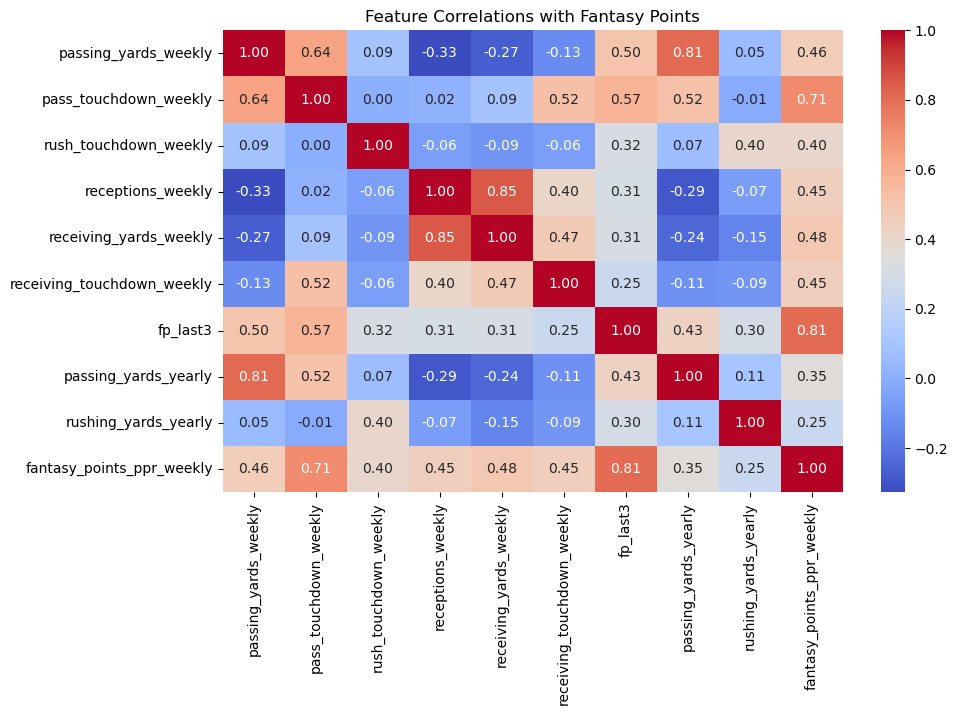

In [28]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_model.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations with Fantasy Points")
plt.show()

The above visulation provides us with an understanding of the correlation between features such as recpetions, receiving yards, rushing yards, and touchdowns. 

We can see that the highest correlation for fantasy points is generated by passing touchdowns(0.71). Followed by receiving yards(0.45), receiving touchdowns(0.45), and rushing touchdowns(0.40).


**Note**: In fantasy drafts, what matters more isn't exact fantasy points, but whether you rank players correctly relative to each other. So I will use **Spearman's Rank Correlation** this will help measure how well the predicted ranks match actual ranks

In [ ]:
rank_corr, _ = spearmanr(y_test, y_pred_lr)
print(f"Spearman Rank Correlation: {rank_corr: .3f}")

Spearman Rank Correlation:  0.971


The model predicted fantasy points rankins are almost perfectly aligned with actyaul weekely rankings of players

* This is what matters for drafting, you care more about whether player A wil outperfom Player B, not if player A scores exactly 14.3 instead of 15.2

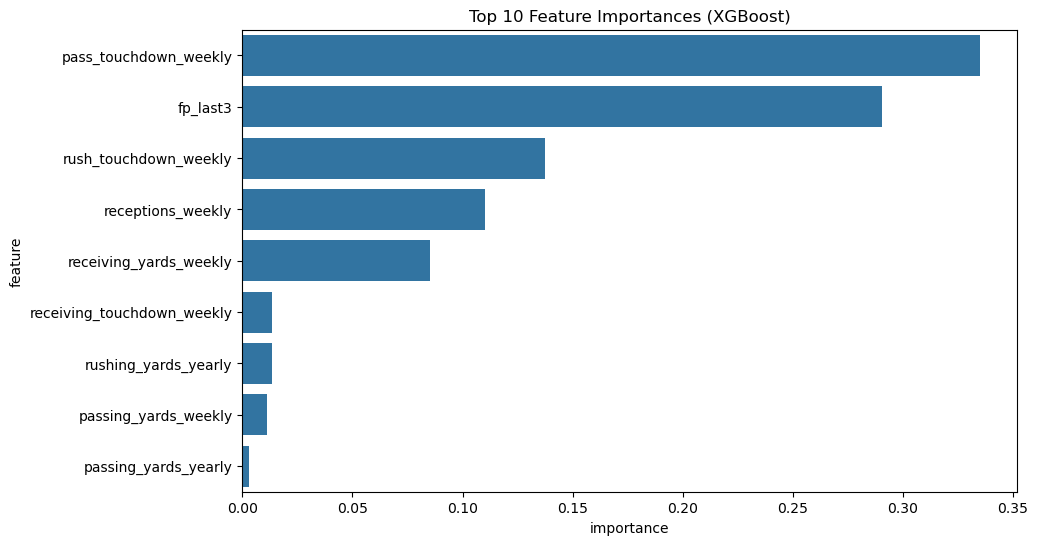

In [31]:
# Feature importance
importances = xgb.feature_importances_
feat_importance = pd.DataFrame({
    'feature': features,  # your original feature list
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance.head(10))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


We will determine what will be the best features that can help obtain the most fantasy points and use Random Forest and XGBoost to improve our model. As we saw from previous visualizations, the best feature is paaong touching,

##### Advanced Regression / Prediction Models

In [29]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=23)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
eval_reg(y_test, y_pred_rf, 'Random Forest Regressor')

--- Random Forest Regressor Metrics ---
 MAE: 1.1081456211351042
 RMSE: 1.8930197992840838
 R2: 0.9546989326508935


In [30]:
rf_rank_corr, _ = spearmanr(y_test, y_pred_rf)
print(f"Random Forest Spearman Rank Correlation: {rank_corr: .3f}")

Random Forest Spearman Rank Correlation:  0.971


baseline R2: 95.4
Baseline MAE: 1.17
Baseline RSME: 1.91

RF R2: 95.5
RF MAE: 1.11
RF RSME: 1.05

With the RandomForestRegressor we can see a slight improvement in the R2, from 95.4 to 95.5. As opposed to the other metrics (MAE, RSME) which saw a decline in performance from 1.17 to 1.11 and 1.91 to 1.05, respectively.

There was change in the Spearman Rank Correlation as it stayed at 0.971


Next, we will try XGBoost to match or increase the baseline numbers and see if we van improve the metrics for Random Forest Regressor

In [31]:
xgb = XGBRegressor(n_estimators=100, 
                    learning_rate=0.05, 
                    max_depth=6, 
                    random_state=23)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
eval_reg(y_test, y_pred_xgb, "XGBoost")

--- XGBoost Metrics ---
 MAE: 1.156366238594957
 RMSE: 1.8793098269979223
 R2: 0.9553527317733034


We see a slight increase from RandomForest Regression.

XGB R2: 0.96

XGB MAE: 1.16

XGB RMSE: 1.08



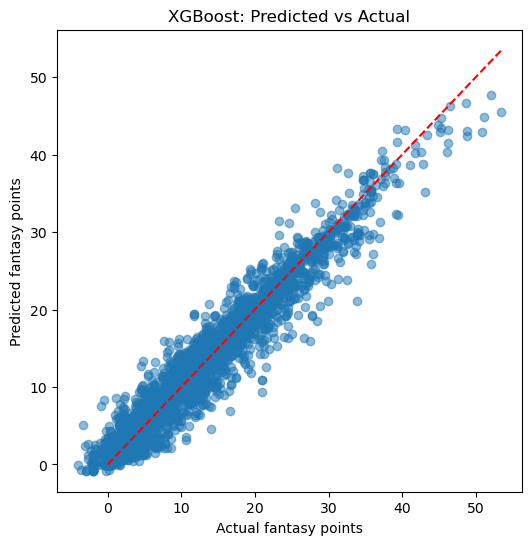

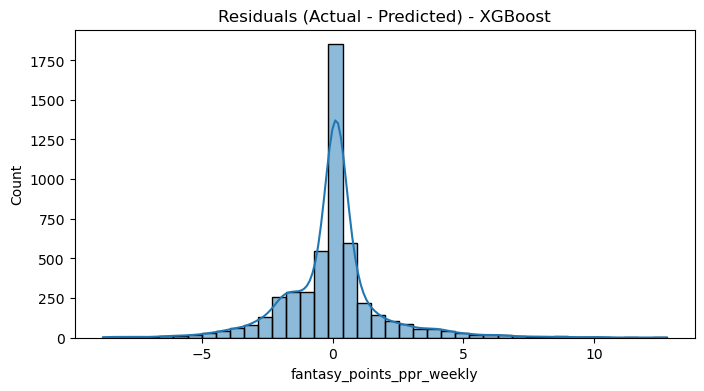

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([0, max(y_test.max(), y_pred_xgb.max())],[0, max(y_test.max(), y_pred_xgb.max())],'r--')
plt.xlabel("Actual fantasy points")
plt.ylabel("Predicted fantasy points")
plt.title("XGBoost: Predicted vs Actual")
plt.show()

# Residuals
resid = y_test - y_pred_xgb
plt.figure(figsize=(8,4))
sns.histplot(resid, bins=40, kde=True)
plt.title("Residuals (Actual - Predicted) - XGBoost")
plt.show()

6b) Feature importance (XGBoost)

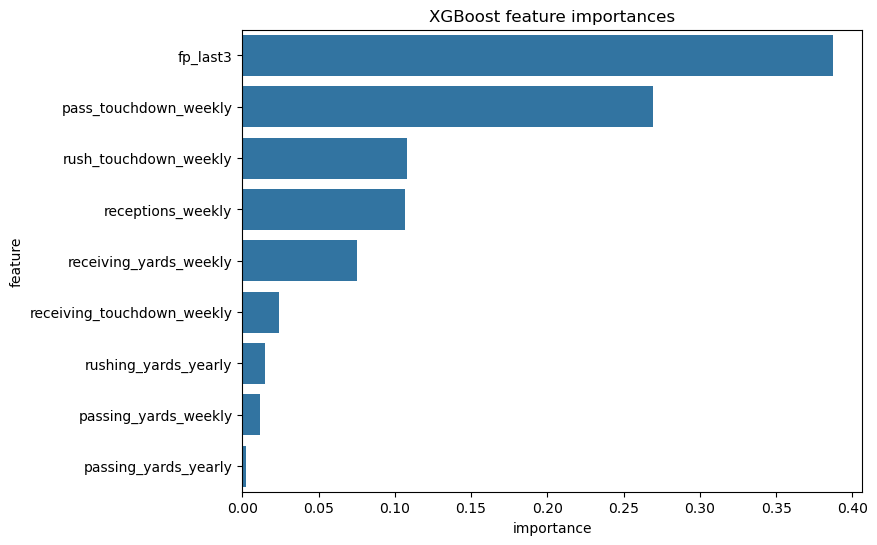

In [34]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi.head(15))
plt.title("XGBoost feature importances")
plt.show()

In [15]:
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

nn.compile(optimizer='adam', loss='mse')
nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn.predict(X_test_scaled).flatten()
print("Neural Network R2:", r2_score(y_test, y_pred_nn))

c:\Users\omend\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Neural Network R2: 0.9586900645048108


In [ ]:
# Correlation heatmap for numeric features

numcols = [
 'passing_yards_weekly','pass_touchdown_weekly','rushing_yards_weekly','rush_touchdown_weekly',
 'receptions_weekly','receiving_yards_weekly','receiving_touchdown_weekly','fp_last3',
 'passing_yards_yearly','rushing_yards_yearly','fantasy_points_ppr_yearly'
]
subset = data_merged[[c for c in numcols if c in data_merged.columns]].dropna()
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected features)")
plt.show()


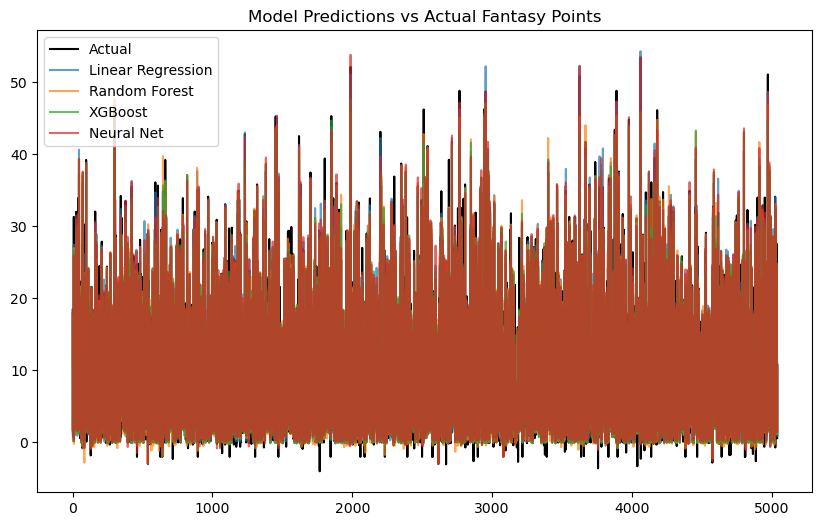

In [16]:
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "Neural Net": y_pred_nn
}

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black")

for name, preds in models.items():
    plt.plot(preds, label=name, alpha=0.7)

plt.legend()
plt.title("Model Predictions vs Actual Fantasy Points")
plt.show()


c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

Next 3 weeks forecast for Patrick Mahomes: [22.70428567386528, 24.24031488756198, 24.504169288543967]


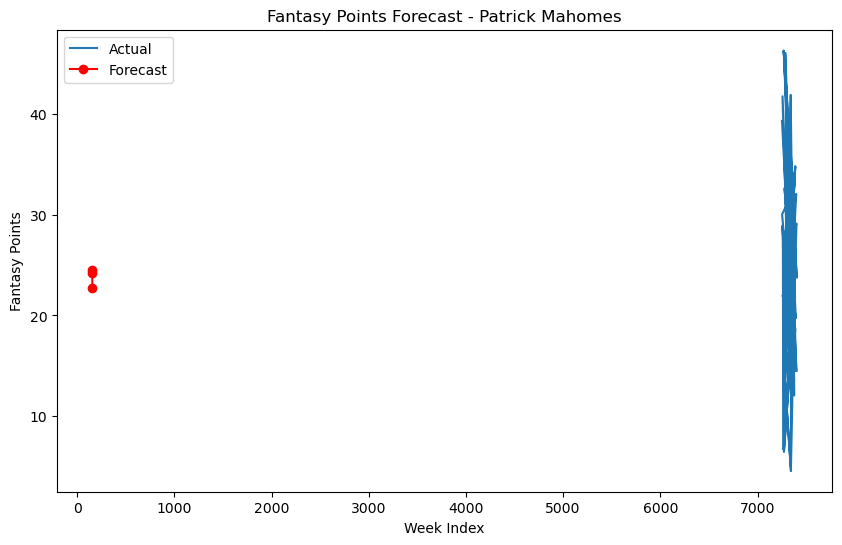

In [18]:
ts = df_player['fantasy_points_ppr_weekly']

# Fit ARIMA
model = ARIMA(ts, order=(2,1,2))  # tune p,d,q
model_fit = model.fit()

# Forecast next 3 weeks
forecast = model_fit.forecast(steps=3)
print(f"Next 3 weeks forecast for {player}: {forecast.tolist()}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(ts.index, ts, label="Actual")
plt.plot(range(len(ts), len(ts)+3), forecast, marker="o", label="Forecast", color="red")
plt.title(f"Fantasy Points Forecast - {player}")
plt.xlabel("Week Index")
plt.ylabel("Fantasy Points")
plt.legend()
plt.show()

In [19]:
df_model

,passing_yards_weekly,pass_touchdown_weekly,rush_touchdown_weekly,receptions_weekly,receiving_yards_weekly,receiving_touchdown_weekly,fp_last3,passing_yards_yearly,rushing_yards_yearly,fantasy_points_ppr_weekly
0,379.0,4.0,0.0,0.0,0.0,0.0,35.160000,329.0,0.0,35.16
1,379.0,4.0,0.0,0.0,0.0,0.0,35.160000,5316.0,81.0,35.16
2,276.0,5.0,0.0,0.0,0.0,0.0,36.900000,329.0,0.0,38.64
3,276.0,5.0,0.0,0.0,0.0,0.0,36.900000,5316.0,81.0,38.64
4,432.0,1.0,1.0,0.0,0.0,0.0,34.826667,329.0,0.0,30.68
...,...,...,...,...,...,...,...,...,...,...
25198,0.0,0.0,0.0,2.0,25.0,0.0,8.066667,0.0,291.0,10.70
25199,0.0,0.0,0.0,0.0,0.0,0.0,8.333333,0.0,291.0,1.80
25200,0.0,0.0,0.0,0.0,0.0,0.0,4.833333,0.0,291.0,2.00
25201,0.0,0.0,0.0,1.0,4.0,0.0,2.233333,0.0,291.0,2.90


In [24]:
data_merged.columns

Index(['player_id', 'player_name_weekly', 'season', 'week',
       'passing_yards_weekly', 'pass_touchdown_weekly', 'rushing_yards_weekly',
       'rush_touchdown_weekly', 'receptions_weekly', 'receiving_yards_weekly',
       'receiving_touchdown_weekly', 'fantasy_points_ppr_weekly', 'fp_last3',
       'player_name_yearly', 'passing_yards_yearly', 'pass_touchdown_yearly',
       'rushing_yards_yearly', 'rush_touchdown_yearly', 'receptions_yearly',
       'receiving_yards_yearly', 'receiving_touchdown_yearly',
       'fantasy_points_ppr_yearly'],
      dtype='object')

In [27]:
from statsmodels.tsa.stattools import adfuller

def forecast_player_arima(player_id, season, steps=3, order=(1,0,1)):
    dfp = data_merged[(data_merged['player_id']==player_id) & (data_merged['season']==season)].sort_values('week')
    ts = dfp['fantasy_points_ppr_yearly'].dropna()
    if len(ts) < 5:
        return None
    try:
        model = ARIMA(ts, order=order)
        fit = model.fit()
        fc = fit.forecast(steps=steps)
        return fc
    except Exception as e:
        print("ARIMA failed for", player_id, e)
        return None

# Example: forecast top player (choose a known id)
example_pid = data_merged['player_id'].iloc[0]
print("Forecast for player_id", example_pid, forecast_player_arima(example_pid, season=2024, steps=3))

#Visualization
# Plot actual and forecast (if returned)
fc = forecast_player_arima(example_pid, 2024, steps=3)
if fc is not None:
    dfp = data_merged[(data_merged['player_id']==example_pid) & (data_merged['season']==2024)].sort_values('week')
    plt.figure(figsize=(8,4))
    plt.plot(dfp['week'], dfp['fantasy_points_ppr'], label='actual')
    plt.plot(range(dfp['week'].max()+1, dfp['week'].max()+1+len(fc)), fc, marker='o', label='forecast')
    plt.legend(); plt.title("ARIMA forecast (player)"); plt.show()


Forecast for player_id 00-0019596 None


Hybrid Recommendation System (synthetic ratings + SVD + hybrid score)

The goal is to generate personlized recommended players (who to draft/start) by blending collaborative filtering (user taste / historical picks) and content/statistics-based predictions.

Symthetic ratings creation (if you don't have user data)

In [ ]:
# Build synthetic ratings from weekly fantasy points:
np.random.seed(3)
players = data_merged['player_id'].unique()
num_users = 50
user_ids = list(range(1, num_users + 1))

ratings = []

player_mean = data_merged.groupby('player_id')['fantasy_points_ppr'].mean().dropna()
for u in user_ids:
    sampled = np.random.choice(player_mean.index, size=25, replace=False)
    for pid in sampled:
        score = player_mean.loc[pid]
        #map score to 1-50 scale (clip)
        rating = float(np.clip(score*3, 1, 50))
        ratings.append([u, int(pid), rating])
        
df_ratings = pd.DataFrame(ratings, columns=['user_id','player_id','rating'])
print(f'Synthetic ratings: {df_ratings.shape}')
        

Train collaborative filtering (SVD)

In [ ]:
reader = Reader(rating_scale=(1,50))
data_cf = Dataset.load_from_df(df_ratings[['user_id','player_id','rating']], reader)
train_cf, test_cf = surprise_split(data_cf, test_size=0.2, random_state=42)
algo = SVD(n_factors=30, random_state=3)
algo.fit(train_cf)
predictions = algo.test(test_cf)
accuracy.rmse(predictions)

Hybrid scorer: blend CF & Stats model

In [ ]:
# Precompute a stats-based baseline: mean weekly fantasy points per player
player_stats_mean = data_merged.groupby('player_id')['fantasy_points_ppr'].mean() 

def hybrid_score(user_id, player_id, e_cf=0.7, w_stats=0.3):
    #CF Prediction
    try:
        pred_cf = algo.predict(user_id, player_id).est
    except:
        pred_cf = player_stats_mean.get(player_id, player_stats_mean.mean())
    pred_stats = player_stats_mean.get(player_id, player_stats_mean.mean())
    return w_cf*pred_cf + w_stats*(pred_stats*3) # scale stats to CF scale if needed

# Example: top 10 for user 1
user = 1
scores = [(pid, hybrid_score(user, pid)) for pid in players]
top10 = sorted(scores, key=lambda x: x[1], reverse=True)[:10]
top10

Visualizations

In [ ]:
top_df = pd.DataFrame(top10, columns=['player_id', 'hybrid_score']).merge(
    data_merged[['player_id', 'player_name']].drop_duplicates('player_id'),
    on='player_id', how='left'
)

sns.barplot(x='hybrid_score', y='player_name', data=top_df)
plt.title('Top 10 hybrid recommendations (user 1)')
plt.show()

9) Build a Draft Board and Simulate a 2025 Roster

    9a) Draft board using season projections

For draft prep we want season-level projections (projected total points) rather than weekly points.

Two options:

Sum weekly predictions across remaining weeks.

Or train on historical season totals as target and predict season totals for 2025.

In [ ]:
# Build season-level mean projection per player using XGBoost or season model
# Here, as a simple example, use historical yearly fantasy_fantasy_ppr_yearly
season_projections = yearly.groupby(['player_id','season'])['fantasy_points_ppr_yearly'].mean().reset_index()
latest_proj = season_projections[season_projections['season']==2024].copy().rename(columns={'fantasy_points_ppr_yearly':'proj_points'})


# 2) compute replacement-level at each position (12-team example)
# you need position info in yearly or weekly (yearly may contain)

pos_map = yearly.set_index('player_id')['position'].to_dict() if 'position' in yearly.columns else {}
latest_proj['position'] = latest_proj['player_id'].map(pos_map)
latest_proj = latest_proj.dropna(subset=['position'])

cutoffs = {'QB': 12, 'RB': 24, 'WR':36, 'TE':12}
vorp_list = []



9b) Simulate picking an optimized roster for 2025

Simplified integer programming (12-team, starting lineup example): choose a roster maximizing sum(proj_points) subject to constraints (1 QB, 2 RB, 2 WR, 1 TE, 1 FLEX(RB/WR/TE), bench size variable). For a single-team pick: